Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


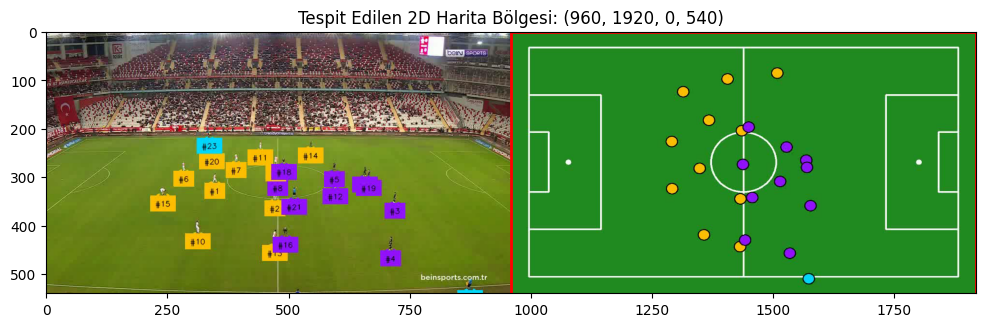

Video boyutları: 1920x540
Otomatik tespit edilen 2D harita bölgesi: (960, 1920, 0, 540)


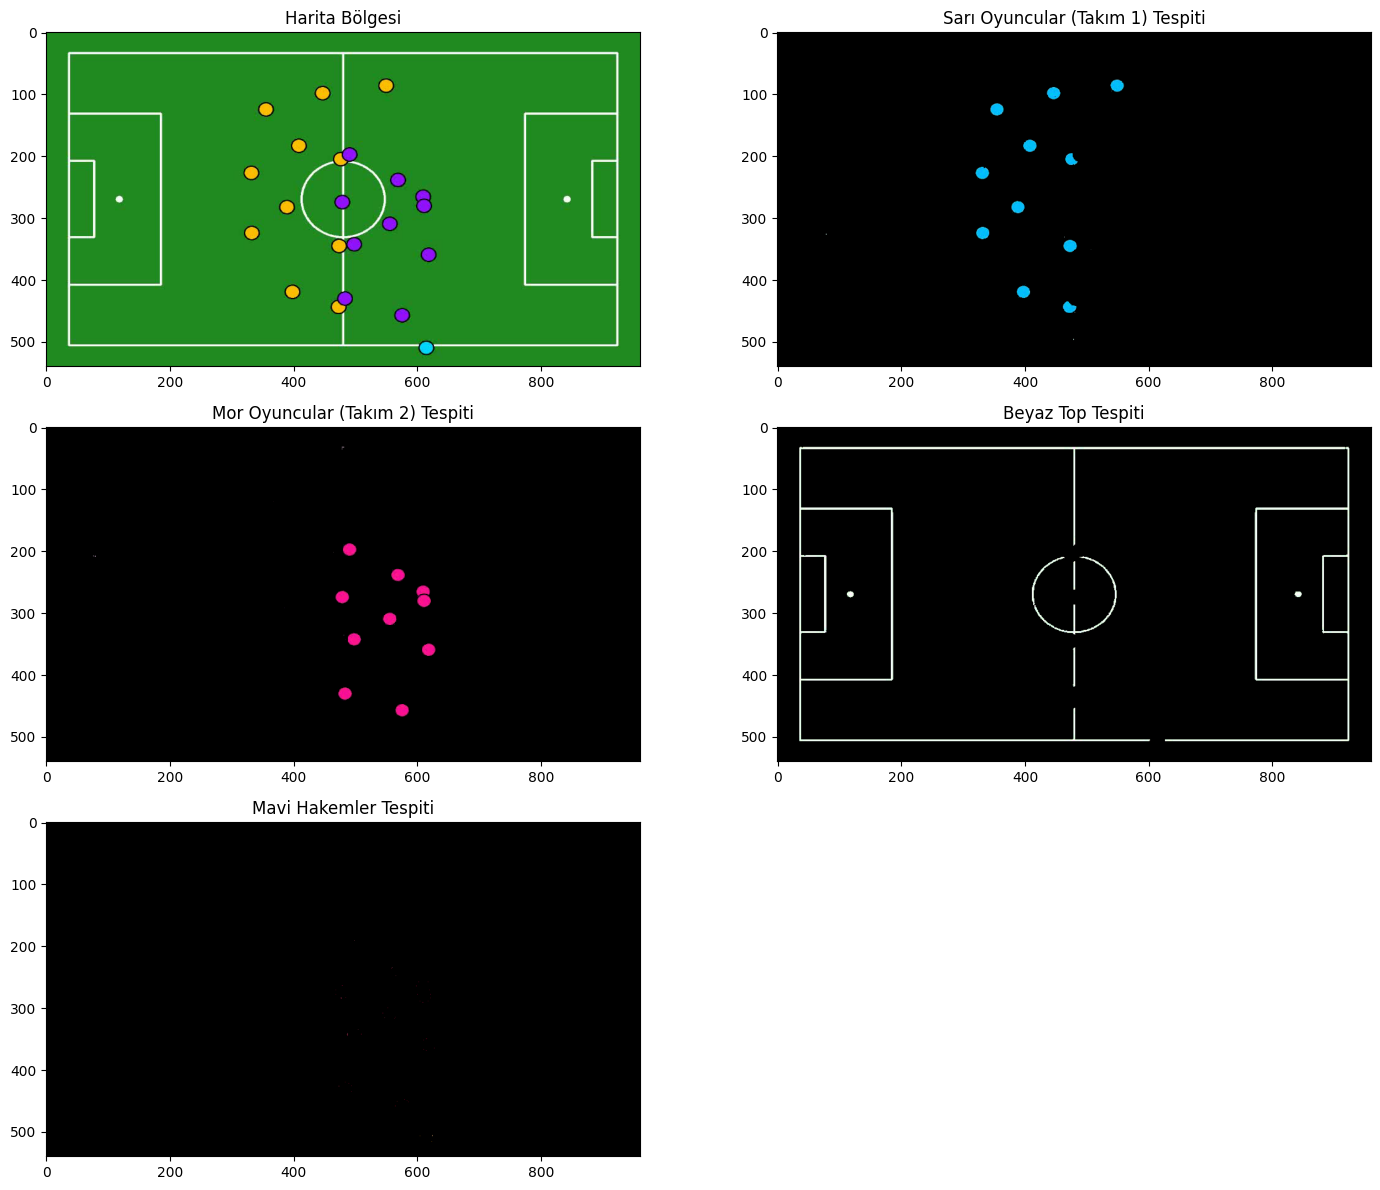

Tespit edilen nesneler:
- Sarı Oyuncular (Takım 1): 11
- Mor Oyuncular (Takım 2): 9
- Beyaz Top: 13
- Mavi Hakemler: 0
Video işleniyor: /content/drive/MyDrive/videos_bein_sports/outputs/last_2023-2024_11_fraport-tav-antalyaspor_besiktas.mp4
Video özellikleri: 1920x540, 25.002 FPS, 12168 toplam frame
Saha çizgileri maskesi oluşturuluyor...


Pas analizi: 100%|██████████| 12168/12168 [03:15<00:00, 62.31it/s]



✅ İşlem tamamlandı! Pas analizi JSON dosyası: /content/drive/MyDrive/videos_bein_sports/betul/pass_analysis_simple.json
✅ Debug videosu: /content/drive/MyDrive/videos_bein_sports/outputs/last_2023-2024_11_fraport-tav-antalyaspor_besiktas_passes.mp4

Pas İstatistikleri:
- Takım 1 (Sarı): 18 pas
- Takım 2 (Mor): 12 pas
- Top Değişimi: 34
✅ Pas haritası oluşturuldu: /content/drive/MyDrive/videos_bein_sports/betul/pass_analysis_simple_map.png


NameError: name 'test_ball_detection' is not defined

In [12]:
# Hücre 1: Kütüphanelerin İçe Aktarılması
import cv2
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hücre 2: Yol ve Parametre Tanımları
from google.colab import drive
drive.mount('/content/drive')

# Hücre 3: Video yolları ve analiz parametreleri
VIDEO_PATH = "/content/drive/MyDrive/videos_bein_sports/outputs/last_2023-2024_11_fraport-tav-antalyaspor_besiktas.mp4"
JSON_PATH = "/content/drive/MyDrive/videos_bein_sports/betul/pass_analysis_simple.json"

# Top sahipliği mesafesi eşiği (piksel)
BALL_POSSESSION_THRESHOLD = 60

# İşlenecek frame aralığı
START_FRAME = 0
MAX_FRAMES = None  # None = tüm videoyu işle

# Hücre 4: Renk aralıkları (HSV formatında)
# Renk aralıkları (HSV formatında) - Genişletilmiş aralıklar
# Sarı oyuncular (Takım 1)
YELLOW_LOWER = np.array([20, 40, 40])  # Daha geniş sarı spektrum için değerler düşürüldü
YELLOW_UPPER = np.array([40, 255, 255])  # Üst sınır genişletildi

# Mavi hakemler - Daha spesifik renk aralığı
BLUE_LOWER = np.array([100, 80, 80])  # Daha yüksek doygunluk
BLUE_UPPER = np.array([130, 255, 255])  # Daha dar aralık

# Beyaz top (düşük doygunluk, yüksek parlaklık)
WHITE_LOWER = np.array([0, 0, 180])  # Parlaklık eşiği biraz düşürüldü
WHITE_UPPER = np.array([180, 50, 255])  # Doygunluk sınırı artırıldı

# Mor oyuncular (Takım 2)
PURPLE_LOWER = np.array([130, 30, 30])  # Daha geniş mor spektrum için değerler düşürüldü
PURPLE_UPPER = np.array([170, 255, 255])  # Üst sınır genişletildi

# Nesne algılama fonksiyonunu düzenleme (min_area azaltılarak küçük nesneleri de yakalayalım)
def detect_objects_by_color(hsv_image, lower_bound, upper_bound, min_area=15):
    """Belirli renk aralığındaki nesneleri tespit eder ve merkez koordinatlarını döndürür."""
    mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

    # Gürültüyü azaltmak için morfolojik işlemler uygulayalım
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    positions = []
    for contour in contours:
        if cv2.contourArea(contour) > min_area:  # Küçük gürültüleri filtrele
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                positions.append((cx, cy))

    return positions

# Renk algılama doğruluğunu artırmak için test fonksiyonu
def test_color_detection(video_path):
    """Belirtilen video üzerinde renk algılama testleri yapar ve sonuçları gösterir."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Hata: Video dosyası açılamadı: {video_path}")
        return

    # İlk 5 kareyi atlayalım (bazen ilk kareler siyah olabiliyor)
    for _ in range(5):
        cap.read()

    # Bir kare alalım
    ret, frame = cap.read()
    if not ret:
        print("Video okunamadı!")
        return

    # 2D harita bölgesini kes
    x_start, x_end, y_start, y_end = MAP_REGION
    map_image = frame[y_start:y_end, x_start:x_end]
    hsv = cv2.cvtColor(map_image, cv2.COLOR_BGR2HSV)

    # Farklı renk aralıkları deneyelim ve sonuçları gösterelim
    plt.figure(figsize=(18, 12))

    # Orijinal görüntü
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))
    plt.title('Orijinal Harita Görüntüsü')

    # Sarı oyuncular için farklı aralıklar
    yellow_ranges = [
        ("Sarı Takım - Standart", YELLOW_LOWER, YELLOW_UPPER),
        ("Sarı Takım - Geniş Aralık", np.array([15, 30, 30]), np.array([45, 255, 255])),
    ]

    for i, (title, lower, upper) in enumerate(yellow_ranges, 2):
        mask = cv2.inRange(hsv, lower, upper)
        result = cv2.bitwise_and(map_image, map_image, mask=mask)
        plt.subplot(2, 3, i)
        plt.imshow(result)
        plt.title(title)

        positions = detect_objects_by_color(hsv, lower, upper, min_area=15)
        print(f"{title}: {len(positions)} nesne tespit edildi")

    # Mor oyuncular için farklı aralıklar
    purple_ranges = [
        ("Mor Takım - Standart", PURPLE_LOWER, PURPLE_UPPER),
        ("Mor Takım - Geniş Aralık", np.array([120, 20, 20]), np.array([180, 255, 255])),
    ]

    for i, (title, lower, upper) in enumerate(purple_ranges, 4):
        mask = cv2.inRange(hsv, lower, upper)
        result = cv2.bitwise_and(map_image, map_image, mask=mask)
        plt.subplot(2, 3, i)
        plt.imshow(result)
        plt.title(title)

        positions = detect_objects_by_color(hsv, lower, upper, min_area=15)
        print(f"{title}: {len(positions)} nesne tespit edildi")

    # Beyaz top için
    white_mask = cv2.inRange(hsv, WHITE_LOWER, WHITE_UPPER)
    white_result = cv2.bitwise_and(map_image, map_image, mask=white_mask)
    plt.subplot(2, 3, 6)
    plt.imshow(white_result)
    plt.title("Beyaz Top")

    # Topu tespit et
    ball_positions, prev_gray = detect_ball_with_combined_features(
        map_image,
        prev_gray,
        field_lines_mask,
        team1_positions,
        team2_positions
    )
    ball_pos = ball_positions[0] if ball_positions else None

    # Renklerin HSV değerlerini manuel olarak incelemek için bir fonksiyon
    def analyze_hsv_values(frame, points=None):
        """Belirtilen konumlardaki HSV değerlerini analiz eder"""
        hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

        if points is None:
            # Eğer özel nokta belirtilmemişse, kullanıcıdan tıklama alın
            plt.figure(figsize=(10, 8))
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title('HSV değerlerini öğrenmek için görüntüye tıklayın')

            def onclick(event):
                if event.xdata is not None and event.ydata is not None:
                    x, y = int(event.xdata), int(event.ydata)
                    if 0 <= x < frame.shape[1] and 0 <= y < frame.shape[0]:
                        hsv_value = hsv_frame[y, x]
                        print(f"Konum ({x}, {y}): HSV = {hsv_value}")

            plt.gcf().canvas.mpl_connect('button_press_event', onclick)
            plt.show()
        else:
            # Belirtilen noktalardaki HSV değerlerini yazdır
            for x, y in points:
                if 0 <= x < frame.shape[1] and 0 <= y < frame.shape[0]:
                    hsv_value = hsv_frame[y, x]
                    print(f"Konum ({x}, {y}): HSV = {hsv_value}")

    # Görüntüyü tıklayarak HSV değerlerini analiz etme
    analyze_hsv_values(map_image)

    cap.release()

    return True

# Renk algılama testini çalıştırma
# test_color_detection(VIDEO_PATH)  # Yorum işaretini kaldırarak çalıştırabilirsiniz

# Hücre 5: Map bölme
def auto_detect_map_region(video_path):
    """Videonun boyutlarını otomatik tespit eder ve 2D harita bölgesini belirler."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Hata: Video dosyası açılamadı: {video_path}")
        return None

    # Video boyutlarını al
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # İlk kareyi al (görselleştirme için)
    ret, first_frame = cap.read()
    cap.release()

    # Varsayılan olarak, videonun sağ yarısı 2D harita
    # (x_başlangıç, x_bitiş, y_başlangıç, y_bitiş)
    map_region = (width//2, width, 0, height)

    if ret:
        # İlk kareyi göster ve kullanıcının harita bölgesini görmesini sağla
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB))

        # Harita bölgesini çiz
        x_start, x_end, y_start, y_end = map_region
        rect = plt.Rectangle((x_start, y_start), x_end-x_start, y_end-y_start,
                            linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)

        plt.title(f"Tespit Edilen 2D Harita Bölgesi: {map_region}")
        plt.show()

    print(f"Video boyutları: {width}x{height}")
    print(f"Otomatik tespit edilen 2D harita bölgesi: {map_region}")

    # Görsel doğrulama için harita bölgesindeki renkleri test et
    if ret:
        map_image = first_frame[y_start:y_end, x_start:x_end]
        hsv = cv2.cvtColor(map_image, cv2.COLOR_BGR2HSV)

        # Sarı oyuncular (Takım 1) maskesi
        yellow_mask = cv2.inRange(hsv, YELLOW_LOWER, YELLOW_UPPER)
        yellow_result = cv2.bitwise_and(map_image, map_image, mask=yellow_mask)

        # Mor oyuncular (Takım 2) maskesi
        purple_mask = cv2.inRange(hsv, PURPLE_LOWER, PURPLE_UPPER)
        purple_result = cv2.bitwise_and(map_image, map_image, mask=purple_mask)

        # Beyaz top maskesi
        white_mask = cv2.inRange(hsv, WHITE_LOWER, WHITE_UPPER)
        white_result = cv2.bitwise_and(map_image, map_image, mask=white_mask)

        # Mavi hakemler maskesi
        blue_mask = cv2.inRange(hsv, BLUE_LOWER, BLUE_UPPER)
        blue_result = cv2.bitwise_and(map_image, map_image, mask=blue_mask)

        plt.figure(figsize=(15, 12))

        plt.subplot(3, 2, 1)
        plt.imshow(cv2.cvtColor(map_image, cv2.COLOR_BGR2RGB))
        plt.title('Harita Bölgesi')

        plt.subplot(3, 2, 2)
        plt.imshow(yellow_result)
        plt.title('Sarı Oyuncular (Takım 1) Tespiti')

        plt.subplot(3, 2, 3)
        plt.imshow(purple_result)
        plt.title('Mor Oyuncular (Takım 2) Tespiti')

        plt.subplot(3, 2, 4)
        plt.imshow(white_result)
        plt.title('Beyaz Top Tespiti')

        plt.subplot(3, 2, 5)
        plt.imshow(blue_result)
        plt.title('Mavi Hakemler Tespiti')

        plt.tight_layout()
        plt.show()

        # Renk tespitinde bulunan nesne sayısını göster
        yellow_objects = len(detect_objects_by_color(hsv, YELLOW_LOWER, YELLOW_UPPER))
        purple_objects = len(detect_objects_by_color(hsv, PURPLE_LOWER, PURPLE_UPPER))
        white_objects = len(detect_objects_by_color(hsv, WHITE_LOWER, WHITE_UPPER, min_area=10))
        blue_objects = len(detect_objects_by_color(hsv, BLUE_LOWER, BLUE_UPPER))

        print("Tespit edilen nesneler:")
        print(f"- Sarı Oyuncular (Takım 1): {yellow_objects}")
        print(f"- Mor Oyuncular (Takım 2): {purple_objects}")
        print(f"- Beyaz Top: {white_objects}")
        print(f"- Mavi Hakemler: {blue_objects}")

        # Eğer tespit yoksa veya çok az nesne tespit edildiyse uyarı ver
        if yellow_objects < 3 and purple_objects < 3:
            print("\n⚠️ UYARI: Yeterli sayıda oyuncu tespit edilemedi. Renk aralıklarını kontrol edin!")
        if white_objects == 0:
            print("\n⚠️ UYARI: Top tespit edilemedi. Beyaz renk aralığını kontrol edin!")

    return map_region

# Hücre 6: MAP_REGION değişkenini ayarla
MAP_REGION = auto_detect_map_region(VIDEO_PATH)

# Hücre 7: Yardımcı Fonksiyonlar

def filter_events(events, min_time_diff=1.0, fps=25.0):
    """Çok sık gerçekleşen olayları filtreler."""
    if not events:
        return []

    filtered_events = [events[0]]  # İlk olayı her zaman dahil et

    for i in range(1, len(events)):
        # Önceki olay ile bu olay arasındaki frame farkı
        frame_diff = events[i]["frame"] - filtered_events[-1]["frame"]
        time_diff = frame_diff / fps  # Saniye cinsinden

        # Eğer zaman farkı yeterince büyükse, olayı dahil et
        if time_diff >= min_time_diff:
            filtered_events.append(events[i])

    return filtered_events

def detect_pass_events(current_team, current_ball_pos, last_team, last_ball_pos, min_distance=50, last_event_frame=None, current_frame=None, min_frame_diff=15):
    """Pas veya top değişimi durumlarını tespit eder."""
    # Top pozisyonu değişti mi?
    if last_ball_pos is None or current_ball_pos is None:
        return None

    # Son olay ile yeni olay arasında yeterli zaman geçti mi?
    if last_event_frame is not None and current_frame is not None:
        if current_frame - last_event_frame < min_frame_diff:
            return None

    # Top ne kadar hareket etti?
    ball_movement_distance = np.sqrt(
        (current_ball_pos[0] - last_ball_pos[0])**2 +
        (current_ball_pos[1] - last_ball_pos[1])**2
    )

    # Hareket yeterince büyük mü?
    if ball_movement_distance < min_distance:
        return None

    # Takımlar değişti mi?
    if current_team is None or last_team is None:
        return None

    if current_team == last_team:
        return "pass"  # Aynı takım içinde pas
    else:
        return "top_degisimi"  # Takımlar arası top değişimi

def calculate_player_vicinity(ball_x, ball_y, team1_positions, team2_positions):
    """Topun oyuncuların yakınında olma olasılığını hesaplar."""
    # Tüm oyuncu pozisyonlarını birleştir
    all_players = team1_positions + team2_positions

    if not all_players:
        return 0.0

    # Top-oyuncu mesafeleri
    distances = []
    for px, py in all_players:
        dist = np.sqrt((ball_x - px)**2 + (ball_y - py)**2)
        distances.append(dist)

    # En yakın iki oyuncu mesafesi
    distances.sort()
    closest_distances = distances[:2] if len(distances) >= 2 else distances

    # En yakın oyuncuya çok yakın olmalı (ideal olarak 10-60 piksel)
    if not closest_distances:
        return 0.0

    closest = closest_distances[0]

    # Çok yakın mesafe skoru (10-60 piksel arası en yüksek)
    if closest < 10:
        proximity_score = closest / 10.0  # 0-1 arası, 10'a yaklaştıkça 1'e yaklaşır
    elif closest <= 60:
        proximity_score = 1.0  # İdeal mesafe
    else:
        proximity_score = max(0, 1.0 - (closest - 60) / 100.0)  # 60'tan uzaklaştıkça azalır

    return proximity_score

def detect_ball_with_combined_features(current_frame, previous_frame, field_lines_mask, team1_positions, team2_positions):
    """Hareket, boyut, renk ve konum özelliklerini birleştirerek topu tespit eder."""
    # Gri tonlamaya dönüştür
    gray_current = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

    # HSV'ye dönüştür
    hsv = cv2.cvtColor(current_frame, cv2.COLOR_BGR2HSV)

    # Beyaz renk maskesi (top için)
    white_mask = cv2.inRange(hsv, WHITE_LOWER, WHITE_UPPER)

    # Hareket tespiti
    if previous_frame is not None:
        # İki frame arasındaki farkı hesapla
        frame_diff = cv2.absdiff(previous_frame, gray_current)
        _, motion_mask = cv2.threshold(frame_diff, 15, 255, cv2.THRESH_BINARY)

        # Morfolojik işlemler
        kernel = np.ones((3, 3), np.uint8)
        motion_mask = cv2.morphologyEx(motion_mask, cv2.MORPH_OPEN, kernel)

        # Statik saha çizgilerini maskele
        if field_lines_mask is not None:
            motion_mask = cv2.bitwise_and(motion_mask, cv2.bitwise_not(field_lines_mask))

        # Hareket eden beyaz nesneler
        combined_mask = cv2.bitwise_and(white_mask, motion_mask)
    else:
        # İlk kare için sadece beyaz maskeyi kullan
        combined_mask = white_mask

        # Statik saha çizgilerini maskele
        if field_lines_mask is not None:
            combined_mask = cv2.bitwise_and(combined_mask, cv2.bitwise_not(field_lines_mask))

    # Konturları bul
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Top adayları
    ball_candidates = []

    # Boyut sınırları
    min_area = 10  # Daha küçük, çünkü top küçük olabilir
    max_area = 200

    # Dairesellik eşiği
    min_circularity = 0.5  # Daha düşük eşik, top her zaman tam daire olmayabilir

    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area <= area <= max_area:
            perimeter = cv2.arcLength(contour, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter * perimeter)

                # Moment hesapla (merkez bulmak için)
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])

                    # Topun oyuncuların arasında olma olasılığını hesapla
                    player_vicinity_score = calculate_player_vicinity(cx, cy, team1_positions, team2_positions)

                    # Toplam skor hesapla (dairesellik ve oyuncu yakınlığı birleştir)
                    total_score = circularity * 0.6 + player_vicinity_score * 0.4

                    # Top adayı olarak ekle
                    ball_candidates.append((cx, cy, total_score))

    # En iyi adayı seç
    if ball_candidates:
        # Toplam skora göre sırala
        ball_candidates.sort(key=lambda x: x[2], reverse=True)
        # En iyi adayı döndür
        return [(ball_candidates[0][0], ball_candidates[0][1])], gray_current

    return [], gray_current

def create_field_lines_mask(map_image):
    """Saha çizgilerini ve diğer statik beyaz işaretleri içeren bir maske oluşturur."""
    # Beyaz renk aralığını kullanarak sahadaki tüm beyaz nesneleri tespit et
    hsv = cv2.cvtColor(map_image, cv2.COLOR_BGR2HSV)
    white_mask = cv2.inRange(hsv, WHITE_LOWER, WHITE_UPPER)

    # Morfolojik işlemler ile çizgileri belirginleştir
    kernel = np.ones((3, 3), np.uint8)
    white_mask = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, kernel)

    # Bu çizgiler genelde sahanın statik parçalarıdır ve bu maskeyi daha sonra
    # top tespitini iyileştirmek için kullanacağız
    return white_mask

# Video işleme başlangıcında bir kez çalıştır
def initialize_field_mask(video_path, map_region, num_frames=10):
    """İlk birkaç kareyi kullanarak sahanın statik öğelerinin maskesini oluşturur."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    masks = []
    for _ in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break

        x_start, x_end, y_start, y_end = map_region
        map_image = frame[y_start:y_end, x_start:x_end]
        masks.append(create_field_lines_mask(map_image))

    cap.release()

    # Tüm maskeleri birleştirerek tutarlı bir statik maske oluştur
    if masks:
        combined_mask = masks[0]
        for mask in masks[1:]:
            combined_mask = cv2.bitwise_or(combined_mask, mask)

        # Gürültüyü azalt ve çizgileri pekiştir
        kernel = np.ones((5, 5), np.uint8)
        combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

        return combined_mask
    return None
def detect_ball_with_motion(current_frame, previous_frame, field_lines_mask, min_area=20, max_area=200, min_circularity=0.7):
    """Hareket tespiti ve statik saha maskesi kullanarak topu tespit eder."""
    # Gri tonlamaya dönüştür
    gray_current = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)

    if previous_frame is None:
        return [], gray_current

    # İki frame arasındaki farkı hesapla
    frame_diff = cv2.absdiff(previous_frame, gray_current)

    # Farkı eşikleme
    _, thresh = cv2.threshold(frame_diff, 15, 255, cv2.THRESH_BINARY)

    # Gürültüyü azalt
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # Statik saha çizgilerini maskele (hariç tut)
    if field_lines_mask is not None:
        thresh = cv2.bitwise_and(thresh, cv2.bitwise_not(field_lines_mask))

    # Beyaz nesneleri tespit et (potansiyel top)
    hsv = cv2.cvtColor(current_frame, cv2.COLOR_BGR2HSV)
    white_mask = cv2.inRange(hsv, WHITE_LOWER, WHITE_UPPER)

    # Sadece hareket eden beyaz nesnelere odaklan
    combined_mask = cv2.bitwise_and(white_mask, thresh)

    # Konturları bul
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ball_candidates = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if min_area <= area <= max_area:  # Alan sınırı
            perimeter = cv2.arcLength(contour, True)
            if perimeter == 0:
                continue

            # Dairesellik hesapla
            circularity = 4 * np.pi * area / (perimeter * perimeter)
            if circularity >= min_circularity:  # Dairesellik kontrolü
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                    ball_candidates.append((cx, cy, circularity, area))

    # Eğer aday varsa, en yüksek daireselliğe sahip olanı seç
    balls = []
    if ball_candidates:
        # Daireselliğe göre sırala
        ball_candidates.sort(key=lambda x: x[2], reverse=True)
        # En iyi adayı al
        balls = [(ball_candidates[0][0], ball_candidates[0][1])]

    return balls, gray_current

def frame_to_time(frame_number, fps):
    """Frame numarasını dakika:saniye formatına dönüştürür."""
    total_seconds = frame_number / fps
    minutes = int(total_seconds // 60)
    seconds = int(total_seconds % 60)
    return f"{minutes}:{seconds:02d}"

def detect_objects_by_color(hsv_image, lower_bound, upper_bound, min_area=30, check_circularity=False, min_circularity=0.7):
    """Belirli renk aralığındaki nesneleri tespit eder ve merkez koordinatlarını döndürür."""
    mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

    # Gürültüyü azaltmak için morfolojik işlemler
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    positions = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_area:  # Küçük gürültüleri filtrele
            # Dairesellik kontrolü
            if check_circularity:
                perimeter = cv2.arcLength(contour, True)
                if perimeter == 0:  # Sıfıra bölmeyi önle
                    continue

                circularity = 4 * np.pi * area / (perimeter * perimeter)
                if circularity < min_circularity:
                    continue  # Yeterince daire şeklinde değilse atla

            M = cv2.moments(contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                positions.append((cx, cy))

    return positions

def find_closest_team(ball_pos, team1_positions, team2_positions, threshold):
    """Topa en yakın oyuncunun hangi takımdan olduğunu bulur."""
    min_distance_team1 = float('inf')
    min_distance_team2 = float('inf')

    # Takım 1 oyuncuları ile mesafe
    for pos in team1_positions:
        distance = np.sqrt((ball_pos[0] - pos[0])**2 + (ball_pos[1] - pos[1])**2)
        min_distance_team1 = min(min_distance_team1, distance)

    # Takım 2 oyuncuları ile mesafe
    for pos in team2_positions:
        distance = np.sqrt((ball_pos[0] - pos[0])**2 + (ball_pos[1] - pos[1])**2)
        min_distance_team2 = min(min_distance_team2, distance)

    # Top hangi takıma daha yakın?
    if min_distance_team1 < threshold and min_distance_team2 < threshold:
        # Her iki takım da yakınsa, hangisi daha yakın?
        return 0 if min_distance_team1 < min_distance_team2 else 1
    elif min_distance_team1 < threshold:
        return 0  # Takım 1
    elif min_distance_team2 < threshold:
        return 1  # Takım 2
    else:
        return None  # Hiçbir takım yakın değil
def create_pass_map(pass_events, output_path):
    """Pas olaylarını gösteren bir harita oluşturur."""
    plt.figure(figsize=(10, 8))

    # Takım 1 pasları (Sarı)
    team1_passes_data = [(e['x'], e['y']) for e in pass_events if e['event_type'] == 'pass' and e['topa_sahip_takım'] == 0]
    if team1_passes_data:
        x1, y1 = zip(*team1_passes_data)
        plt.scatter(x1, y1, c='yellow', alpha=0.7, label='Takım 1 (Sarı) Pasları')

    # Takım 2 pasları (Mor)
    team2_passes_data = [(e['x'], e['y']) for e in pass_events if e['event_type'] == 'pass' and e['topa_sahip_takım'] == 1]
    if team2_passes_data:
        x2, y2 = zip(*team2_passes_data)
        plt.scatter(x2, y2, c='purple', alpha=0.7, label='Takım 2 (Mor) Pasları')

    # Top değişimi
    top_degisimi_data = [(e['x'], e['y']) for e in pass_events if e['event_type'] == 'top_degisimi']
    if top_degisimi_data:
        x3, y3 = zip(*top_degisimi_data)
        plt.scatter(x3, y3, c='red', alpha=0.7, label='Top Değişimleri')

    plt.title('Pas ve Top Değişimi Haritası')
    plt.xlabel('X Koordinatı')
    plt.ylabel('Y Koordinatı')
    plt.legend()
    plt.grid(True)

    plt.savefig(output_path)
    plt.close()

    print(f"✅ Pas haritası oluşturuldu: {output_path}")

def create_field_lines_mask(map_image):
    """Saha çizgilerini ve diğer statik beyaz işaretleri içeren bir maske oluşturur."""
    # Beyaz renk aralığını kullanarak sahadaki tüm beyaz nesneleri tespit et
    hsv = cv2.cvtColor(map_image, cv2.COLOR_BGR2HSV)
    white_mask = cv2.inRange(hsv, WHITE_LOWER, WHITE_UPPER)

    # Morfolojik işlemler ile çizgileri belirginleştir
    kernel = np.ones((3, 3), np.uint8)
    white_mask = cv2.morphologyEx(white_mask, cv2.MORPH_CLOSE, kernel)

    # Bu çizgiler genelde sahanın statik parçalarıdır ve bu maskeyi daha sonra
    # top tespitini iyileştirmek için kullanacağız
    return white_mask

def initialize_field_mask(video_path, map_region, num_frames=10):
    """İlk birkaç kareyi kullanarak sahanın statik öğelerinin maskesini oluşturur."""
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return None

    masks = []
    for _ in range(num_frames):
        ret, frame = cap.read()
        if not ret:
            break

        x_start, x_end, y_start, y_end = map_region
        map_image = frame[y_start:y_end, x_start:x_end]
        masks.append(create_field_lines_mask(map_image))

    cap.release()

    # Tüm maskeleri birleştirerek tutarlı bir statik maske oluştur
    if masks:
        combined_mask = masks[0]
        for mask in masks[1:]:
            combined_mask = cv2.bitwise_or(combined_mask, mask)

        # Gürültüyü azalt ve çizgileri pekiştir
        kernel = np.ones((5, 5), np.uint8)
        combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

        return combined_mask
    return None


# Hücre 8: Ana Pas Analizi Fonksiyonu
def analyze_passes_from_2d_map(
    input_video_path,
    output_json_path,
    start_frame=0,
    max_frames=None,
    ball_possession_threshold=60,  # 30'dan 60'a yükseltildi
    map_region=(640, 1280, 0, 720)
):
    """
    2D harita görüntüsü içeren futbol maçı videosundan pas analizi yapar.

    Args:
        input_video_path: Giriş videosu (bir tarafı maç, diğer tarafı 2D harita)
        output_json_path: Pas analizinin kaydedileceği JSON dosyası
        start_frame: Başlangıç frame numarası
        max_frames: İşlenecek maksimum frame sayısı
        ball_possession_threshold: Top sahipliği mesafesi eşiği (piksel)
        map_region: 2D haritanın görüntüdeki konumu (x_başlangıç, x_bitiş, y_başlangıç, y_bitiş)
    """

    print(f"Video işleniyor: {input_video_path}")

    # Video okuyucu
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print(f"Hata: Video dosyası açılamadı: {input_video_path}")
        return

    # Video özellikleri
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    print(f"Video özellikleri: {width}x{height}, {fps} FPS, {total_frames} toplam frame")

    # Statik saha çizgileri maskesi oluştur
    print("Saha çizgileri maskesi oluşturuluyor...")
    field_lines_mask = initialize_field_mask(input_video_path, map_region)

    # Başlangıç frame'ine git
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    # İşlenecek frame sayısını belirle
    if max_frames is None:
        max_frames = total_frames - start_frame
    frames_to_process = min(max_frames, total_frames - start_frame)

    # Pas analizi değişkenleri
    pass_events = []
    last_ball_pos = None
    last_possessor_team = None
    prev_gray = None
    last_event_frame = None

    # Debug için video çıktısı oluştur
    debug_output = None
    if input_video_path.endswith('.mp4'):
        debug_output_path = input_video_path.replace('.mp4', '_passes.mp4')
        debug_output = cv2.VideoWriter(
            debug_output_path,
            cv2.VideoWriter_fourcc(*'mp4v'),
            fps,
            (width, height)
        )

    # Ana işleme döngüsü
    with tqdm(total=frames_to_process, desc="Pas analizi") as pbar:
        for frame_count in range(frames_to_process):
            ret, frame = cap.read()
            if not ret:
                break

            # 2D harita bölgesini kes
            x_start, x_end, y_start, y_end = map_region
            map_image = frame[y_start:y_end, x_start:x_end]

            # Debug görüntüsü oluştur
            debug_image = frame.copy()

            # HSV'ye dönüştür
            hsv = cv2.cvtColor(map_image, cv2.COLOR_BGR2HSV)

            # Takım 1 (Sarı) oyuncuları tespit et
            team1_positions = detect_objects_by_color(hsv, YELLOW_LOWER, YELLOW_UPPER)

            # Takım 2 (Mor) oyuncuları tespit et
            team2_positions = detect_objects_by_color(hsv, PURPLE_LOWER, PURPLE_UPPER)

            # Hakemleri tespit et (Mavi)
            referee_positions = detect_objects_by_color(hsv, BLUE_LOWER, BLUE_UPPER)

            # Topu tespit et (beyaz renk)
            ball_positions, prev_gray = detect_ball_with_motion(
                map_image,
                prev_gray,
                field_lines_mask,
                min_area=20,
                max_area=200,
                min_circularity=0.7
            )
            ball_pos = ball_positions[0] if ball_positions else None

            # Debug görüntüsünde oyuncuları, hakemleri ve topu işaretle
            for pos in team1_positions:
                cv2.circle(debug_image, (pos[0] + x_start, pos[1] + y_start), 10, (0, 255, 255), -1)  # Sarı

            for pos in team2_positions:
                cv2.circle(debug_image, (pos[0] + x_start, pos[1] + y_start), 10, (255, 0, 255), -1)  # Mor

            for pos in referee_positions:
                cv2.circle(debug_image, (pos[0] + x_start, pos[1] + y_start), 10, (255, 0, 0), -1)  # Mavi

            if ball_pos:
                cv2.circle(debug_image, (ball_pos[0] + x_start, ball_pos[1] + y_start), 5, (255, 255, 255), -1)  # Beyaz

            # Eğer top tespit edildiyse pas analizini yap
            if ball_pos is not None:
                # Topa en yakın takımı bul
                current_possessor_team = find_closest_team(
                    ball_pos, team1_positions, team2_positions, ball_possession_threshold
                )

                # Pas veya top değişimi kontrolü
                if last_ball_pos is not None and last_possessor_team is not None:
                    current_frame = start_frame + frame_count

                    event_type = detect_pass_events(
                        current_possessor_team, ball_pos,
                        last_possessor_team, last_ball_pos,
                        min_distance=50,  # 20'den 50'ye yükseltildi
                        last_event_frame=last_event_frame,
                        current_frame=current_frame,
                        min_frame_diff=15  # Minimum 15 frame (yaklaşık 0.5 sn) bekle
                    )

                    if event_type is not None:
                        time_str = frame_to_time(current_frame, fps)

                        # JSON için olay kaydı
                        event = {
                            "zaman": time_str,
                            "frame": int(current_frame),
                            "topa_sahip_takım": int(current_possessor_team) if current_possessor_team is not None else -1,
                            "event_type": event_type,
                            "x": float(ball_pos[0]),
                            "y": float(ball_pos[1])
                        }

                        # Debug çıktısına olayı göster
                        text = f"{time_str} - {event_type.upper()}: Takım {current_possessor_team + 1 if current_possessor_team is not None else 'Belirsiz'}"
                        cv2.putText(debug_image, text, (50, 50),
                                  cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                        pass_events.append(event)
                        last_event_frame = current_frame  # Son olay frame'ini güncelle

                # Son top pozisyonunu güncelle
                last_ball_pos = ball_pos
                last_possessor_team = current_possessor_team

            # İstatistikleri ekle
            team1_passes = sum(1 for event in pass_events if event['event_type'] == 'pass' and event['topa_sahip_takım'] == 0)
            team2_passes = sum(1 for event in pass_events if event['event_type'] == 'pass' and event['topa_sahip_takım'] == 1)
            top_degisimi = sum(1 for event in pass_events if event['event_type'] == 'top_degisimi')

            cv2.putText(
                debug_image,
                f"Takım 1 (Sarı) Pas: {team1_passes}, Takım 2 (Mor) Pas: {team2_passes}, Top Değişimi: {top_degisimi}",
                (10, height - 20),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.7,
                (255, 255, 255),
                2
            )

            # Debug görüntüsünü kaydet
            if debug_output is not None:
                debug_output.write(debug_image)

            # İlerleme çubuğunu güncelle
            pbar.update(1)

    # Kaynakları serbest bırak
    cap.release()
    if debug_output is not None:
        debug_output.release()

    # Çok sık olayları filtrele (en az 1 saniye ara)
    filtered_pass_events = filter_events(pass_events, min_time_diff=1.0, fps=fps)

    # Filtrelenmiş olayları JSON'a kaydet
    with open(output_json_path, 'w', encoding='utf-8') as f:
        json.dump(filtered_pass_events, f, ensure_ascii=False, indent=4)

    # İstatistikleri güncelle (filtrelenmiş olaylar üzerinden)
    team1_passes = sum(1 for event in filtered_pass_events if event['event_type'] == 'pass' and event['topa_sahip_takım'] == 0)
    team2_passes = sum(1 for event in filtered_pass_events if event['event_type'] == 'pass' and event['topa_sahip_takım'] == 1)
    top_degisimi = sum(1 for event in filtered_pass_events if event['event_type'] == 'top_degisimi')

    print(f"\n✅ İşlem tamamlandı! Pas analizi JSON dosyası: {output_json_path}")
    if debug_output is not None:
        print(f"✅ Debug videosu: {debug_output_path}")

    # İstatistikleri göster
    print("\nPas İstatistikleri:")
    print(f"- Takım 1 (Sarı): {team1_passes} pas")
    print(f"- Takım 2 (Mor): {team2_passes} pas")
    print(f"- Top Değişimi: {top_degisimi}")

    # Pas haritası oluştur
    passes_map_path = output_json_path.replace('.json', '_map.png')
    create_pass_map(filtered_pass_events, passes_map_path)

    return filtered_pass_events

# Hücre 9: Programı Çalıştırma
if __name__ == "__main__" or 'google.colab' in str(get_ipython()):
    pass_events = analyze_passes_from_2d_map(
        input_video_path=VIDEO_PATH,
        output_json_path=JSON_PATH,
        start_frame=START_FRAME,
        max_frames=MAX_FRAMES,
        ball_possession_threshold=BALL_POSSESSION_THRESHOLD,
        map_region=MAP_REGION
    )

# Hücre 10: JSON Verilerini Analiz Etme (İsteğe Bağlı)
def analyze_json_data(json_path):
    """JSON dosyasındaki pas verilerini analiz eder."""
    # JSON dosyasını oku
    with open(json_path, 'r', encoding='utf-8') as f:
        pass_events = json.load(f)

    # Takım bazında istatistikler
    team1_passes = [e for e in pass_events if e['event_type'] == 'pass' and e['topa_sahip_takım'] == 0]
    team2_passes = [e for e in pass_events if e['event_type'] == 'pass' and e['topa_sahip_takım'] == 1]
    top_changes = [e for e in pass_events if e['event_type'] == 'top_degisimi']

    # Saha bölgeleri analizi
    def get_pitch_zone(x, y, map_width, map_height):
        """X,Y koordinatlarına göre sahanın hangi bölgesinde olduğunu belirler."""
        x_zone = "Sol" if x < map_width/3 else ("Orta" if x < 2*map_width/3 else "Sağ")
        y_zone = "Üst" if y < map_height/3 else ("Orta" if y < 2*map_height/3 else "Alt")
        return f"{y_zone} {x_zone}"

    # Her bir pas için saha bölgesini hesapla
    map_width = MAP_REGION[1] - MAP_REGION[0]
    map_height = MAP_REGION[3] - MAP_REGION[2]

    for event in pass_events:
        event['saha_bolgesi'] = get_pitch_zone(event['x'], event['y'], map_width, map_height)

    # Bölge bazında istatistikler
    zone_stats = {}
    for event in pass_events:
        zone = event['saha_bolgesi']
        team = event['topa_sahip_takım']
        event_type = event['event_type']

        if zone not in zone_stats:
            zone_stats[zone] = {'team1_passes': 0, 'team2_passes': 0, 'top_changes': 0}

        if event_type == 'pass':
            if team == 0:
                zone_stats[zone]['team1_passes'] += 1
            else:
                zone_stats[zone]['team2_passes'] += 1
        else:
            zone_stats[zone]['top_changes'] += 1

    # Sonuçları yazdır
    print(f"\n📊 Pas Analizi Sonuçları ({len(pass_events)} toplam olay):")
    print(f"Takım 1 (Sarı): {len(team1_passes)} pas")
    print(f"Takım 2 (Mor): {len(team2_passes)} pas")
    print(f"Top Değişimi Sayısı: {len(top_changes)}")

    print("\n🏟️ Saha Bölgeleri Analizi:")
    for zone, stats in zone_stats.items():
        print(f"{zone} Bölgesi:")
        print(f"  - Takım 1 (Sarı) Pas: {stats['team1_passes']}")
        print(f"  - Takım 2 (Mor) Pas: {stats['team2_passes']}")
        print(f"  - Top Değişimi: {stats['top_changes']}")

    # Bölge bazlı görselleştirme
    plt.figure(figsize=(12, 8))
    zones = list(zone_stats.keys())
    team1_data = [zone_stats[z]['team1_passes'] for z in zones]
    team2_data = [zone_stats[z]['team2_passes'] for z in zones]

    x = np.arange(len(zones))
    width = 0.35

    plt.bar(x - width/2, team1_data, width, label='Takım 1 (Sarı)', color='yellow')
    plt.bar(x + width/2, team2_data, width, label='Takım 2 (Mor)', color='purple')

    plt.xlabel('Saha Bölgesi')
    plt.ylabel('Pas Sayısı')
    plt.title('Bölge Bazında Pas Dağılımı')
    plt.xticks(x, zones, rotation=45)
    plt.legend()
    plt.tight_layout()

    # Grafiği kaydet
    chart_path = json_path.replace('.json', '_bolge_analizi.png')
    plt.savefig(chart_path)
    plt.close()

    print(f"\n✅ Bölge analizi grafiği oluşturuldu: {chart_path}")

    return pass_events, zone_stats

# Test_ball_detection'ı çalıştır
test_ball_detection(VIDEO_PATH, MAP_REGION)  # Yorum işaretini kaldırarak çalıştırabilirsiniz

# Hücre 11: Verileri Analiz Et (İsteğe Bağlı)
# analyze_json_data(JSON_PATH)  # Yorum işaretini kaldırarak çalıştırabilirsiniz